In [30]:
# Import dependencies
import sys
import random
from collections import deque
from typing import List, Tuple, Deque

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from IPython.display import clear_output

# Utility functions
def install_dependencies_if_needed() -> None:
    """Install dependencies if using Google Colab."""
    if "google.colab" in sys.modules:
        import os
        os.system("apt install python-opengl ffmpeg xvfb")
        os.system("pip install pyvirtualdisplay")
        from pyvirtualdisplay import Display
        display = Display(visible=0, size=(600, 400))
        display.start()

def set_random_seed(seed: int) -> None:
    """Set a random seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# Network Layers
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Initialize uniform parameters for the layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)
    return layer

class Actor(nn.Module):
    """Policy network for PPO."""
    def __init__(self, input_dim: int, output_dim: int, log_std_range: Tuple[int, int] = (-20, 0)):
        super().__init__()
        self.log_std_min, self.log_std_max = log_std_range
        self.hidden = nn.Linear(input_dim, 32)
        self.mu_layer = init_layer_uniform(nn.Linear(32, output_dim))
        self.log_std_layer = init_layer_uniform(nn.Linear(32, output_dim))

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, Normal]:
        x = F.relu(self.hidden(state))
        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.tanh(self.log_std_layer(x))
        log_std = self.log_std_min + 0.5 * (self.log_std_max - self.log_std_min) * (log_std + 1)
        std = torch.exp(log_std)
        dist = Normal(mu, std)
        action = dist.sample()
        return action, dist

class Critic(nn.Module):
    """Value network for PPO."""
    def __init__(self, input_dim: int):
        super().__init__()
        self.hidden = nn.Linear(input_dim, 64)
        self.out = init_layer_uniform(nn.Linear(64, 1))

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.hidden(state))
        return self.out(x)

# Advantage Estimation
def compute_gae(next_value: torch.Tensor, rewards: List[torch.Tensor], masks: List[torch.Tensor], values: List[torch.Tensor], gamma: float, tau: float) -> List[torch.Tensor]:
    """Generalized Advantage Estimation (GAE)."""
    values = values + [next_value]
    gae = 0
    returns: Deque[torch.Tensor] = deque()
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.appendleft(gae + values[step])
    return list(returns)

# Data Sampler
def ppo_iter(epoch: int, mini_batch_size: int, *tensors: torch.Tensor) -> Tuple[torch.Tensor, ...]:
    """Yield mini-batches for training."""
    batch_size = tensors[0].size(0)
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.choice(batch_size, mini_batch_size)
            yield tuple(tensor[rand_ids] for tensor in tensors)

class PPOAgent:
    """PPO Agent Implementation."""
    def __init__(self, env: gym.Env, gamma: float, tau: float, batch_size: int, epsilon: float, epoch: int, rollout_len: int, entropy_weight: float):
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.005)
        self.clear_memory()
        self.total_step = 1
        self.is_test = False

    def clear_memory(self) -> None:
        """Clear training memory."""
        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action
        if not self.is_test:
            value = self.critic(state)
            self.states.append(state)
            self.actions.append(selected_action)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(selected_action))
        return selected_action.cpu().detach().numpy()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the environment response."""
        next_state, reward, done, _ = self.env.step(action)
        next_state = np.reshape(next_state, (1, -1)).astype(np.float64)
        reward = np.reshape(reward, (1, -1)).astype(np.float64)
        done = np.reshape(done, (1, -1))
        if not self.is_test:
            self.rewards.append(torch.FloatTensor(reward).to(self.device))
            self.masks.append(torch.FloatTensor(1 - done).to(self.device))
        return next_state, reward, done

    def update_model(self, next_state: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update model parameters."""
        next_state = torch.FloatTensor(next_state).to(self.device)
        next_value = self.critic(next_state)
        returns = compute_gae(next_value, self.rewards, self.masks, self.values, self.gamma, self.tau)
        returns = torch.cat(returns).detach()  # Ensure `returns` is a tensor
        values = torch.cat(self.values).detach()
        advantages = returns - values  # Correct subtraction
        states = torch.cat(self.states)
        actions = torch.cat(self.actions)
        log_probs = torch.cat(self.log_probs).detach()
        actor_losses, critic_losses = [], []
        for batch in ppo_iter(self.epoch, self.batch_size, states, actions, values, log_probs, returns, advantages):
            state, action, old_value, old_log_prob, return_, adv = batch
            _, dist = self.actor(state)
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp()
            surr_loss = ratio * adv
            clipped_surr_loss = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv
            entropy = dist.entropy().mean()
            actor_loss = -torch.min(surr_loss, clipped_surr_loss).mean() - entropy * self.entropy_weight
            value = self.critic(state)
            critic_loss = (return_ - value).pow(2).mean()
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
        self.clear_memory()
        return sum(actor_losses) / len(actor_losses), sum(critic_losses) / len(critic_losses)

    def train(self, num_frames: int, plotting_interval: int = 200) -> None:
        """Train the agent using PPO."""
        self.is_test = False
        state = np.expand_dims(self.env.reset(), axis=0)
        actor_losses, critic_losses, scores, score = [], [], [], 0
        while self.total_step <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_step += 1
                action = self.select_action(state)
                state, reward, done = self.step(action)
                score += reward[0][0]
                if done[0][0]:
                    state = np.expand_dims(self.env.reset(), axis=0)
                    scores.append(score)
                    score = 0
                    self._plot(self.total_step, scores, actor_losses, critic_losses)
            actor_loss, critic_loss = self.update_model(state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
        self.env.close()

    def test(self) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        state = self.env.reset()
        done, score = False, 0
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            state, reward, done = self.step(action)
            score += reward
        print("score: ", score)
        self.env.close()
        return frames


    def _plot(self, frame_idx: int, scores: List[float], actor_losses: List[float], critic_losses: List[float]) -> None:
        """Visualize training progress."""
        def subplot(loc: int, title: str, values: List[float]) -> None:
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)
        params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses)
        ]
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in params:
            subplot(loc, title, values)
        plt.show()

class ActionNormalizer(gym.ActionWrapper):
    """Normalize and rescale actions."""
    def action(self, action: np.ndarray) -> np.ndarray:
        low, high = self.action_space.low, self.action_space.high
        scale_factor, reloc_factor = (high - low) / 2, high - (high - low) / 2
        return np.clip(action * scale_factor + reloc_factor, low, high)

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        low, high = self.action_space.low, high
        scale_factor, reloc_factor = (high - low) / 2, high - (high - low) / 2
        return np.clip((action - reloc_factor) / scale_factor, -1.0, 1.0)





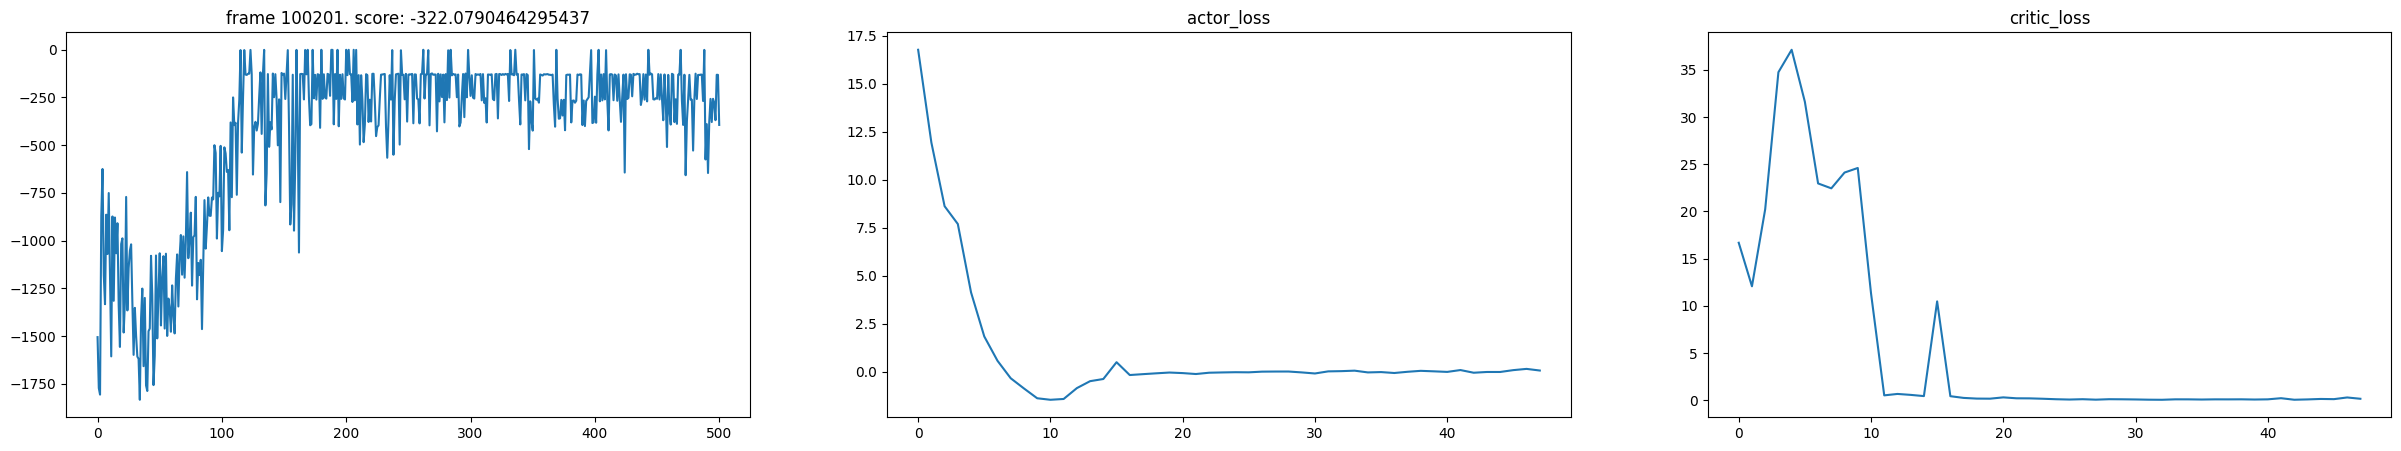

In [32]:
# Configure Environment
env_id, seed = "Pendulum-v1", 529
install_dependencies_if_needed()
set_random_seed(seed)
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

# Instantiate and Train Agent
num_frames = 100000
agent = PPOAgent(env, gamma=0.9, tau=0.8, batch_size=64, epsilon=0.2, epoch=64, rollout_len=2048, entropy_weight=0.005)
agent.train(num_frames)